In [1]:
#Necessary
from fastai.fastai.text import *
from sklearn.metrics import confusion_matrix, f1_score, classification_report

import html
import csv

C:\Users\leond\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Necessary
BOS = "xbos " #beginning-of-sentence tag
FLD = "xfld " #data field tag
TURN = " eot "
CLASSES = ["angry", "sad", "happy", "others"]



In [3]:
#Necessary
PATH=Path("starterkitdata/")
CLAS_PATH = Path("emo_clas/")
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path("emo_lm/")
LM_PATH.mkdir(exist_ok=True)

In [4]:
#Necessary
def get_texts(path):
    texts, labels, data = [],[],[]

    with open(path, "r", encoding="utf-8") as dataset:
        reader = csv.reader(dataset, delimiter="\t")
        next(reader, None) #skip header
        data = list(reader)
    dataset.close()
    for turn in data:
        texts.append(BOS+turn[1]+TURN+turn[2]+TURN+turn[3])
        if len(turn) == 5: #skip non existant label when reading in testdata
            labels.append(CLASSES.index(turn[4]))
    return np.array(texts), np.array(labels)

ratio = 10 #ratio of train to validation

trn_texts, trn_labels = get_texts(PATH/"train.txt")
tst_texts, _ = get_texts(PATH/"devwithoutlabels.txt")
val_texts, val_labels = trn_texts[:int(len(trn_texts)/ratio)], trn_labels[:int(len(trn_labels)/ratio)]
trn_texts, trn_labels = trn_texts[int(len(trn_texts)/ratio):], trn_labels[int(len(trn_labels)/ratio):]

In [5]:
len(trn_texts), len(val_texts), len(tst_texts)

(27144, 3016, 2755)

In [6]:
#Necessary
col_names = ["labels", "text"]

In [7]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [8]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]


In [9]:
#Necessary
df_trn = pd.DataFrame({"text":trn_texts, "labels":trn_labels}, columns=col_names)
df_val = pd.DataFrame({"text":val_texts, "labels":val_labels}, columns=col_names)
df_tst = pd.DataFrame({"text":tst_texts, "labels":[0]*len(tst_texts)}, columns=col_names)

Get Weights for class imbalance

In [10]:
#Necessary
trn_labelcounts = df_trn.groupby(["labels"]).size()
val_labelcounts = df_val.groupby(["labels"]).size()
trn_label_sum = len(df_trn["labels"])
val_label_sum = len(df_val["labels"])
trn_weights = [count/trn_label_sum for count in trn_labelcounts]
val_weights = [count/val_label_sum for count in val_labelcounts]
trn_weights, val_weights

([0.1814765694076039,
  0.18155025051576776,
  0.14135720601237842,
  0.49561597406424995],
 [0.19230769230769232,
  0.1773872679045093,
  0.1346153846153846,
  0.4956896551724138])

In [11]:
#Necessary
rtd_val_weights = [max(val_weights)/value for value in trn_weights]
rtd_val_weights

[2.7314250913520097, 2.7303165584415585, 3.5066458170445665, 1.000148665725117]

In [12]:
df_trn.to_csv(CLAS_PATH/"train.csv", header=False, index=False)
df_val.to_csv(CLAS_PATH/"test.csv", header=False, index=False)
df_tst.to_csv(CLAS_PATH/"tst.csv", header=False, index=False)

(CLAS_PATH/"classes.txt").open("w").writelines(f"{o}\n" for o in CLASSES)

In [13]:
df_trn.head()

,labels,text
0,0,xbos I am not getting you! eot just don't get ...
1,1,"xbos I wanna meet my bf eot take your time, ve..."
2,3,xbos Why eot i know :) eot Can you love me
3,3,xbos Pink eot lol.... all in pink... anything ...
4,3,xbos Cooking? eot luv cooking eot Cool


In [14]:
(CLAS_PATH/"classes.txt").open().readlines()

['angry\n', 'sad\n', 'happy\n', 'others\n']

In [15]:
df_trn = pd.DataFrame({"text":trn_texts, "labels":[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({"text":val_texts, "labels":[0]*len(val_texts)}, columns=col_names)
#df_tst bereits mit 0 Label initialisiert

df_trn.to_csv(LM_PATH/"train.csv", header=False, index=False)
df_val.to_csv(LM_PATH/"test.csv", header=False, index=False)
df_tst.to_csv(LM_PATH/"tst.csv", header=False, index=False)

Tokenization

In [16]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [17]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [18]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [19]:
chunksize = 5000
df_trn = pd.read_csv(LM_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/"test.csv", header=None, chunksize=chunksize)
df_tst = pd.read_csv(LM_PATH/"tst.csv", header=None, chunksize=chunksize)

In [20]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

0
1
2
3
4
5
0
0


In [21]:
(LM_PATH/"tmp").mkdir(exist_ok=True)

In [22]:
np.save(LM_PATH/"tmp"/"tok_trn.npy",tok_trn)
np.save(LM_PATH/"tmp"/"tok_val.npy",tok_val)
np.save(LM_PATH/"tmp"/"tok_tst.npy",tok_tst)

In [20]:
tok_trn = np.load(LM_PATH/"tmp"/"tok_trn.npy")
tok_val = np.load(LM_PATH/"tmp"/"tok_val.npy")
tok_tst = np.load(LM_PATH/"tmp"/"tok_tst.npy")

In [21]:
freq = Counter(p for o in tok_trn for p in o) #o = review (list of tokenized sentences), p = sentence
freq.most_common(25)

[('eot', 54288),
 ('xbos', 27144),
 ('i', 21853),
 ('you', 19001),
 ('?', 12381),
 ('.', 10837),
 ('to', 7266),
 ('me', 7155),
 ('do', 6802),
 ('what', 6414),
 ('u', 6132),
 ('!', 5515),
 ('are', 5423),
 ('it', 5144),
 ('a', 5117),
 ('is', 4546),
 ('not', 4466),
 ("n't", 4409),
 ('the', 4357),
 ('my', 3795),
 ('t_up', 3750),
 ('that', 3716),
 (',', 3658),
 ('so', 3510),
 ('am', 3338)]

In [22]:
len(freq)

14076

In [23]:
max_vocab = 5000
min_freq = 5

In [24]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] #Sort out all words that apper less than max_vocab with bigger freq than min_freq
itos.insert(0, "_unk_") #words that did not appear before or not frequent enough
itos.insert(1, "_pad_")

In [25]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)}) #dictionary with index numbers sorted by freq
len(itos)

2925

In [26]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])
tst_lm = np.array([[stoi[o] for o in p] for p in tok_tst])

In [27]:
np.save(LM_PATH/"tmp"/"trn_ids.npy", trn_lm)
np.save(LM_PATH/"tmp"/"val_ids.npy", val_lm)
np.save(LM_PATH/"tmp"/"tst_ids.npy", tst_lm)
pickle.dump(itos, open(LM_PATH/"tmp"/"itos.pkl","wb"))

In [28]:
#necessary
trn_lm = np.load(LM_PATH/"tmp"/"trn_ids.npy")
val_lm = np.load(LM_PATH/"tmp"/"val_ids.npy")
tst_lm = np.load(LM_PATH/"tmp"/"tst_ids.npy")
itos = pickle.load(open(LM_PATH/"tmp"/"itos.pkl","rb"))

In [29]:
#necessary
vs = len(itos) #vocabsize
vs, len(trn_lm), len(val_lm), len(tst_lm)

(2925, 27144, 3016, 2755)

Wikitext103

In [30]:
#necessary
em_sz,nh,nl = 400,1150,3 #embedding, hidden_size, hidden_layer - values of original wikitext model

In [31]:
PRE_PATH = PATH/"models"/"sem140"
PRE_LM_PATH = PRE_PATH/"sem140.h5"

In [32]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage) #load wikitext weights

In [33]:
enc_wgts = to_np(wgts["0.encoder.weight"])
row_m = enc_wgts.mean(0) #mean used for unknown tokens

Map Vocabularies on each other

In [34]:
itos2 = pickle.load((PRE_PATH/"itos_sem140.pkl").open("rb"))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})
len(stoi2)

41813

In [35]:
new_w = np.zeros((vs, em_sz), dtype=np.float32) #0-matrix vocab-size*embedding-size
for i,w in enumerate(itos): #Go through vocab of turn dataset
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m #if word exists copy weight, otherwise average weight

In [36]:
wgts["0.encoder.weight"] = T(new_w)
wgts["0.encoder_with_dropout.embed.weight"] = T(np.copy(new_w))
wgts["1.decoder.weight"] = T(np.copy(new_w))

## Language Model

In [37]:
wd = 1e-5
bptt = 70
bs = 150
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [38]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
tst_dl = LanguageModelLoader(np.concatenate(tst_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, tst_dl, bs=bs, bptt=bptt)

In [39]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*1.6 #1.8 smaller dataset = higher multiplicator

In [40]:
md.trn_dl.data = md.trn_dl.data.long()
md.val_dl.data = md.val_dl.data.long()
md.test_dl.data = md.test_dl.data.long()

Initialize missing tokens with mean weights. So freeze everything except last layer

In [41]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [42]:
learner.model.load_state_dict(wgts)

In [43]:
learner.lr_find2(end_lr=0.2, wds=wd, num_it=46, linear=True)

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Missing key(s) in state_dict: "0.rnns.0.module.weight_hh_l0", "0.rnns.1.module.weight_hh_l0", "0.rnns.2.module.weight_hh_l0". 

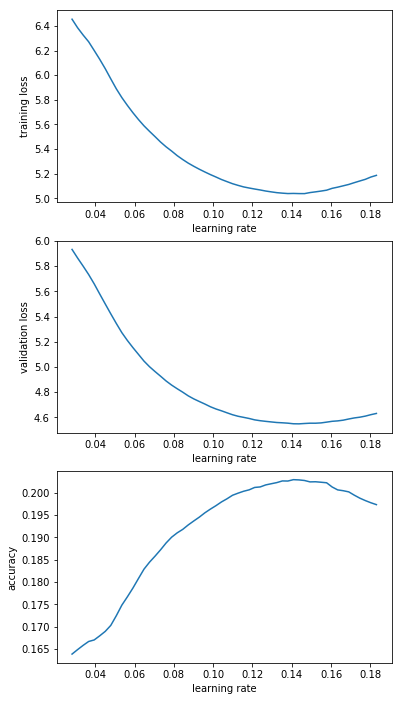

In [44]:
learner.sched.plot()

In [45]:
lr = 0.16
lrs = lr

In [46]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.913666   4.091487   0.232201  


[4.091487288475037, 0.23220084235072136]

In [47]:
learner.save('lm_last_ft')

In [48]:
learner.load('lm_last_ft')

In [49]:
learner.unfreeze()

In [50]:
learner.lr_find2(end_lr=0.04, wds=wd, num_it=45)

 96%|███████████████████████████████████████████████████████████████████▉   | 45/47 [00:16<00:00,  2.55it/s, loss=4.42]

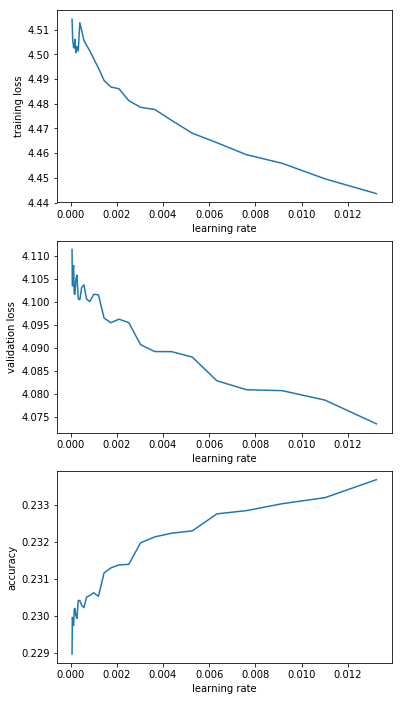

In [51]:
learner.sched.plot()

In [52]:
lrs = 0.012

In [53]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.295503   3.913218   0.250777  
    1      4.13411    3.768452   0.288139                                                                              
    2      3.951502   3.62062    0.315169                                                                              
    3      3.830185   3.589751   0.31632                                                                               
    4      3.727961   3.551252   0.321947                                                                              
    5      3.650887   3.554199   0.3206                                                                                
    6      3.595599   3.520659   0.324575                                                                              
    7      3.526611   3.515914   0.324803                                                                           

[3.4736019372940063, 0.3335471674799919]

In [54]:
learner.save("lm1")

In [55]:
learner.save_encoder("lm1_enc")

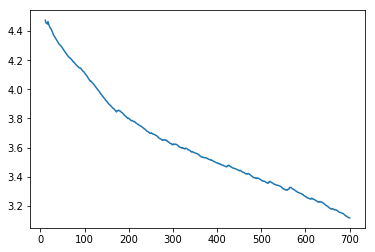

In [56]:
learner.sched.plot_loss()

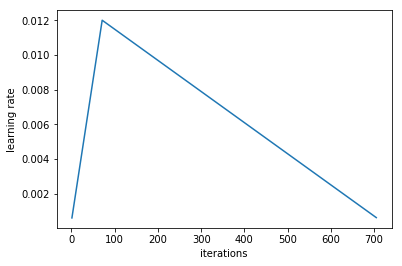

In [57]:
learner.sched.plot_lr()

In [58]:
df_trn = pd.read_csv(CLAS_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"test.csv", header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/"tst.csv", header=None, chunksize=chunksize)

In [59]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tol_tst, tst_labels = get_all(df_tst, 1)

0
1
2
3
4
5
0
0


In [60]:
(CLAS_PATH/"tmp").mkdir(exist_ok=True)

np.save(CLAS_PATH/"tmp"/"tok_trn.npy", tok_trn)
np.save(CLAS_PATH/"tmp"/"tok_val.npy", tok_val)
np.save(CLAS_PATH/"tmp"/"tok_tst.npy", tok_tst)

np.save(CLAS_PATH/"tmp"/"trn_labels.npy", trn_labels)
np.save(CLAS_PATH/"tmp"/"val_labels.npy", val_labels)
np.save(CLAS_PATH/"tmp"/"tst_labels.npy", tst_labels)

In [37]:
#necessary
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/"tmp"/"tok_tst.npy")

In [38]:
#Necessary
itos = pickle.load((LM_PATH/"tmp"/"itos.pkl").open("rb"))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

2925

In [39]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [40]:
np.save(CLAS_PATH/"tmp"/"trn_ids.npy", trn_clas)
np.save(CLAS_PATH/"tmp"/"val_ids.npy", val_clas)
np.save(CLAS_PATH/"tmp"/"tst_ids.npy", tst_clas)

## Classifier

In [41]:
#Necessary
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
tst_clas = np.load(CLAS_PATH/"tmp"/"tst_ids.npy")

In [42]:
#Necessary
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
tst_labels = np.squeeze(np.load(CLAS_PATH/"tmp"/"tst_labels.npy"))

In [43]:
#Necessary
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 150

In [44]:
#Necessary
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
tst_labels -= min_lbl
c=int(trn_labels.max())+1

In [45]:
#Necessary
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
tst_ds = TextDataset(tst_clas, tst_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))  #sorts dataset by length to reduce too strongly padded tensors
tst_samp = SortSampler(tst_clas, key=lambda x: len(tst_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1)
md = ModelData(PATH, trn_dl, val_dl, tst_dl)

In [46]:
#Necessary
dps = np.array([0.4,0.5,0.05,0.3,0.4])*1.2

In [47]:
#Necessary
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                       layers=[em_sz*3, 50,c], drops=[dps[4], 0.2],
                      dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
#check dropout layers

In [48]:
#Necessary
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]
loss_weights = torch.FloatTensor(rtd_val_weights).cuda()
learn.crit = partial(F.cross_entropy, weight=loss_weights)

In [49]:
wd = 1e-6
learn.load_encoder("lm1_enc")

In [50]:
learn.unfreeze()

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.564429   0.578548   0.791421  


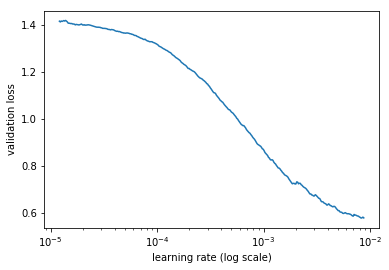

In [76]:
learn.lr_find(end_lr=1e-2, wds=wd)
learn.sched.plot()

In [77]:
lrs = 10e-3

In [78]:
learn.freeze_to(-1)

In [79]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=1, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_lm1')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.692395   0.442233   0.789456  


[0.4422328615417847, 0.789456251801167]

In [80]:
learn.save('clas_0')

In [106]:
learn.load('best_lm1')

In [82]:
learn.freeze_to(-2)

In [83]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=1, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_lm2')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.480724   0.289348   0.864722  


[0.28934813331842263, 0.8647215044229669]

In [84]:
learn.save('clas_1')

In [56]:
learn.load('clas_1')

In [57]:
learn.unfreeze()

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.411986   0.284662   0.890354  



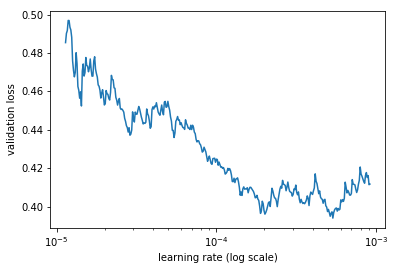

In [58]:
learn.lr_find(end_lr=10e-4, wds=wd)
learn.sched.plot()

In [59]:
lrs = 2*10e-4

In [60]:
learn.fit(lrs, 1, wds=wd, use_wd_sched=True, cycle_len=10, use_clr_beta=(10,10,0.95,0.85), best_save_name='best_classifier')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.378679   0.247257   0.894231  
    1      0.347516   0.223694   0.91313                                                                               
    2      0.321025   0.228166   0.904509                                                                              
    3      0.305984   0.22442    0.907493                                                                              
    4      0.323772   0.210758   0.915451                                                                              
    5      0.288862   0.233264   0.912798                                                                              
    6      0.241622   0.225971   0.916114                                                                              
    7      0.208673   0.22127    0.916114                                                                           

[0.2301094884729749, 0.924734769077769]

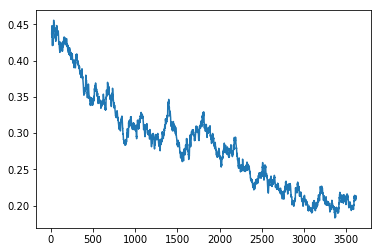

In [61]:
learn.sched.plot_loss()

In [62]:
learn.save('clas_2')

In [63]:
learn.load("best_classifier")

In [64]:
val_lbls = np.load(CLAS_PATH/'tmp'/'val_labels.npy').flatten()
val_lbls_sampled = val_lbls[list(val_samp)]
predictions = np.argmax(learn.predict(), axis=1)
acc = (val_lbls_sampled == predictions).mean()
print("Accuracy =", acc, ", \nConfusion Matrix =")
clas_labels = [0,1,2,3]
print(confusion_matrix(val_lbls_sampled, predictions, labels=clas_labels))
print("F-Score: ", f1_score(val_lbls_sampled, predictions, average="weighted"))
print("Sem-eval F-Score: ", f1_score(val_lbls_sampled, predictions, labels=[0,1,2], average="micro"))


print(classification_report(val_lbls_sampled, predictions))


Accuracy = 0.9247347480106101 , 
Confusion Matrix =
[[ 531   19    2   28]
 [  20  502    0   13]
 [   1    1  393   11]
 [  52   26   54 1363]]
F-Score:  0.9250386307940436
Sem-eval F-Score:  0.9135169762972454
             precision    recall  f1-score   support

          0       0.88      0.92      0.90       580
          1       0.92      0.94      0.93       535
          2       0.88      0.97      0.92       406
          3       0.96      0.91      0.94      1495

avg / total       0.93      0.92      0.93      3016



## Submission

### Classifier weight tuning

In [65]:
predictions = np.argmax(learn.predict(True), axis=1)
predictions[:10]

array([0, 3, 2, 2, 1, 3, 0, 3, 3, 1], dtype=int64)

In [81]:
x = [1,1,1,1] #[0.3,0.5,1.5,1]
rtd_val_weights_clas = [x[i]/value for i, value in enumerate(rtd_val_weights)]
rtd_val_weights_clas

[0.3661092530657748,
 0.3662578966926793,
 0.28517279821627645,
 0.9998513563730955]

In [82]:
preds = learn.predict(True)*rtd_val_weights_clas
preds = np.argmax(preds, axis=1)
preds[:30], predictions[:30]

(array([0, 3, 2, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3], dtype=int64),
 array([0, 3, 2, 2, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3], dtype=int64))

In [83]:
x = np.unique(preds, return_counts=True)
y = np.unique(predictions, return_counts=True)

x[1]/[[np.sum(x[1])]*len(x[1])], y[1]/[[np.sum(y[1])]*len(y[1])]

(array([[0.05844, 0.04537, 0.049  , 0.84719]]),
 array([[0.08494, 0.05263, 0.07223, 0.7902 ]]))

### Create output

In [86]:
def create_output():
    output = []
    output.append(["id","turn1", "turn2", "turn3", "label"])
    preds = learn.predict(True)#*rtd_val_weights_clas
    predictions = np.argmax(preds, axis=1) #(True = Testset)
    
    
    for i, text in enumerate(tst_texts):
        turns = text.split("eot")
        turns[0] = " ".join(turns[0].split()[1:])
        output.append([str(i),turns[0].strip(), turns[1].strip(), turns[2].strip(), CLASSES[predictions[i]]])
    return output

In [87]:
def write_sample():
    outputs = create_output()
    with open("test.txt", "w", encoding="utf-8") as writer:
        for output_set in outputs:
            line = "\t".join(output_set)
            writer.write(line+"\n")
write_sample()

In [4]:
np.exp(3.91)

49.89895197340787